# ESL on Cifar-10 dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 20
num_classes = 10

In [3]:
# Load data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

val_size = 5000
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 201s 1us/step


Epoch 1/20, Time: 21.29s, Loss: 1.4621, Val_Loss: 0.9928, Val_Acc: 0.6502
Epoch 2/20, Time: 7.85s, Loss: 1.0392, Val_Loss: 0.8233, Val_Acc: 0.7124
Epoch 3/20, Time: 4.65s, Loss: 0.8902, Val_Loss: 0.8654, Val_Acc: 0.6948
Epoch 4/20, Time: 5.22s, Loss: 0.7996, Val_Loss: 0.7287, Val_Acc: 0.7492
Epoch 5/20, Time: 5.28s, Loss: 0.7295, Val_Loss: 0.7874, Val_Acc: 0.7312
Epoch 6/20, Time: 4.60s, Loss: 0.6826, Val_Loss: 0.6801, Val_Acc: 0.7692
Epoch 7/20, Time: 4.82s, Loss: 0.6361, Val_Loss: 0.6933, Val_Acc: 0.7666
Epoch 8/20, Time: 4.73s, Loss: 0.5953, Val_Loss: 0.6502, Val_Acc: 0.7806
Epoch 9/20, Time: 4.94s, Loss: 0.5483, Val_Loss: 0.5956, Val_Acc: 0.7946
Epoch 10/20, Time: 4.92s, Loss: 0.5231, Val_Loss: 0.6703, Val_Acc: 0.7748
Epoch 11/20, Time: 4.89s, Loss: 0.4917, Val_Loss: 0.5693, Val_Acc: 0.8128
Epoch 12/20, Time: 4.97s, Loss: 0.4592, Val_Loss: 0.6327, Val_Acc: 0.7920
Epoch 13/20, Time: 6.52s, Loss: 0.4348, Val_Loss: 0.5977, Val_Acc: 0.8048
Epoch 14/20, Time: 4.59s, Loss: 0.4151, Val_Lo

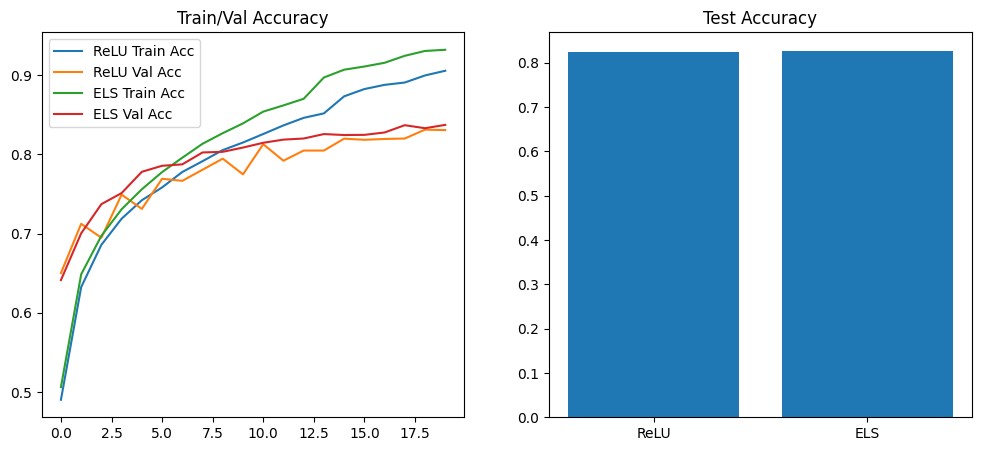

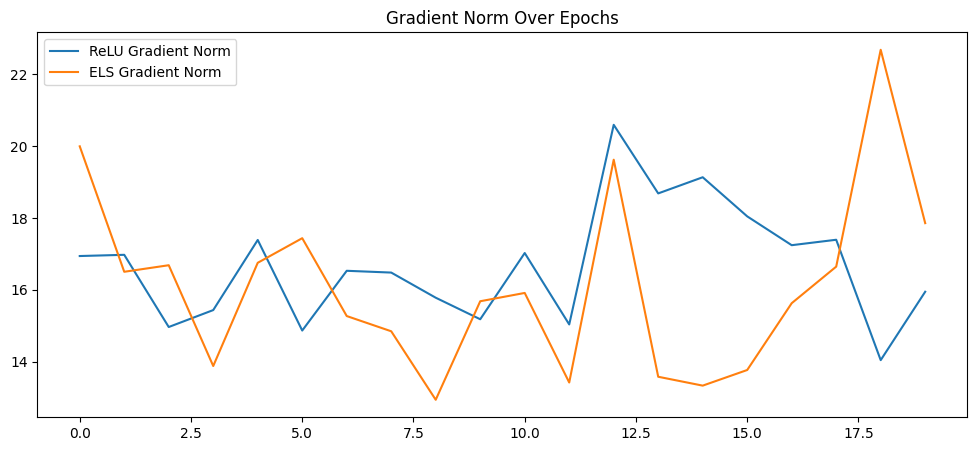

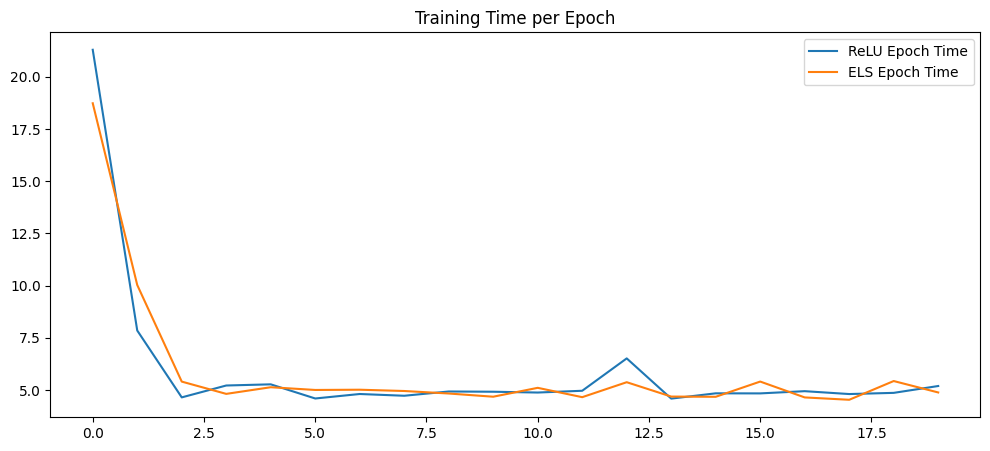

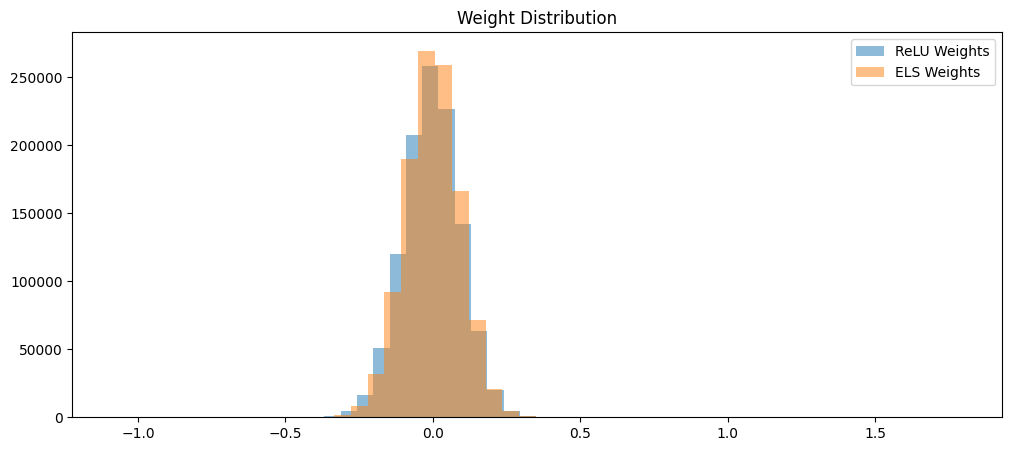

ReLU Model:
Test Accuracy: 0.8237
Sparsity: 0.0001
Total Training Time: 118.80s
ELS Model:
Test Accuracy: 0.8271
Sparsity: 0.0001
Total Training Time: 118.10s


In [6]:


def els(x):
    return tf.where(x>=0, x, x*tf.exp(x))

initializer = tf.keras.initializers.HeNormal()

def build_model(activation_func):
    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)
model_relu.save("model_relu_final.keras")

model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)
model_els.save("model_els_final.keras")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='ELS Train Acc')
plt.plot(history_els.history['val_accuracy'], label='ELS Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')

plt.show()

plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='ELS Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='ELS Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='ELS Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("ELS Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")


In [7]:
epochs = 100

Epoch 1/100, Time: 17.90s, Loss: 1.4537, Val_Loss: 1.0342, Val_Acc: 0.6230
Epoch 2/100, Time: 4.79s, Loss: 1.0174, Val_Loss: 0.8472, Val_Acc: 0.7042
Epoch 3/100, Time: 5.29s, Loss: 0.8771, Val_Loss: 0.7783, Val_Acc: 0.7198
Epoch 4/100, Time: 4.79s, Loss: 0.7890, Val_Loss: 0.7225, Val_Acc: 0.7464
Epoch 5/100, Time: 4.84s, Loss: 0.7201, Val_Loss: 0.6718, Val_Acc: 0.7638
Epoch 6/100, Time: 5.02s, Loss: 0.6714, Val_Loss: 0.6385, Val_Acc: 0.7806
Epoch 7/100, Time: 4.81s, Loss: 0.6201, Val_Loss: 0.6429, Val_Acc: 0.7788
Epoch 8/100, Time: 4.94s, Loss: 0.5822, Val_Loss: 0.5757, Val_Acc: 0.7986
Epoch 9/100, Time: 4.64s, Loss: 0.5413, Val_Loss: 0.5802, Val_Acc: 0.7998
Epoch 10/100, Time: 4.63s, Loss: 0.5054, Val_Loss: 0.5717, Val_Acc: 0.8028
Epoch 11/100, Time: 4.97s, Loss: 0.4762, Val_Loss: 0.5700, Val_Acc: 0.8056
Epoch 12/100, Time: 4.63s, Loss: 0.4519, Val_Loss: 0.6083, Val_Acc: 0.7920
Epoch 13/100, Time: 5.31s, Loss: 0.4287, Val_Loss: 0.5761, Val_Acc: 0.8066
Epoch 14/100, Time: 5.09s, Loss: 

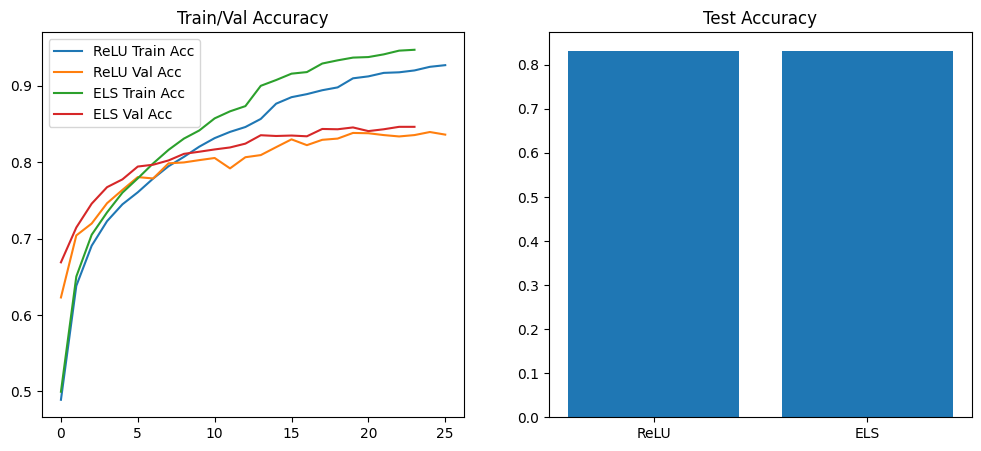

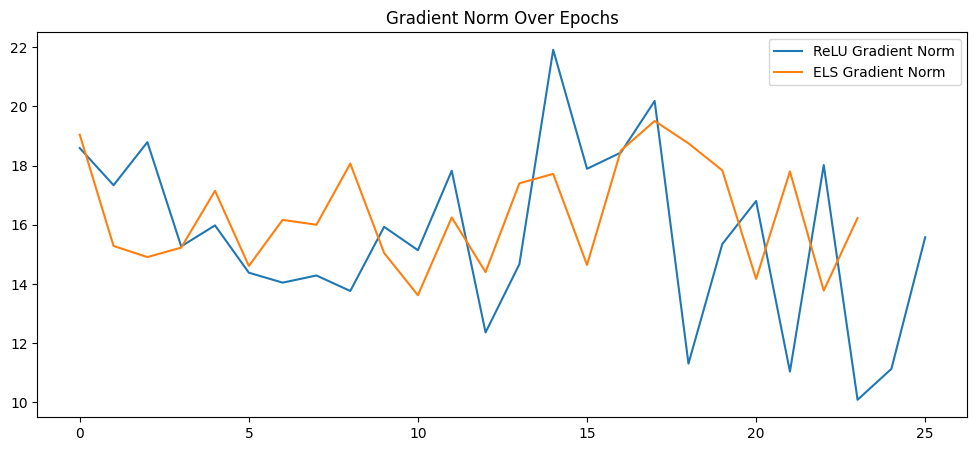

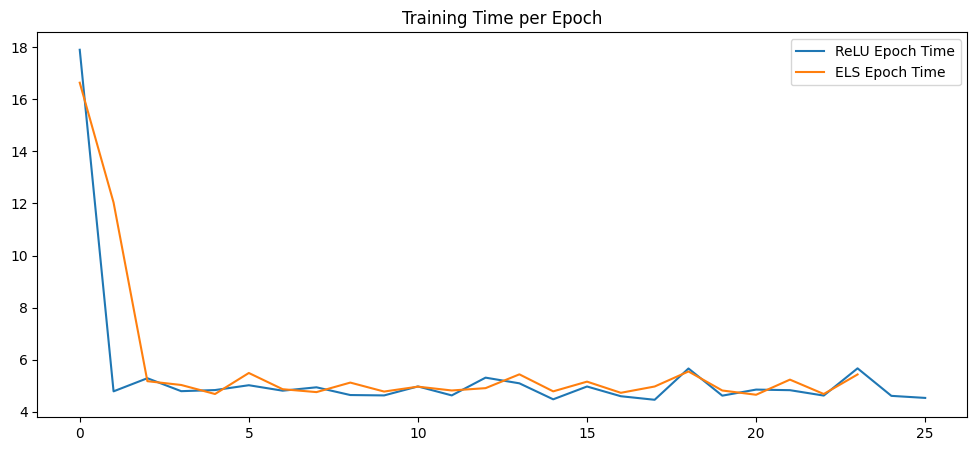

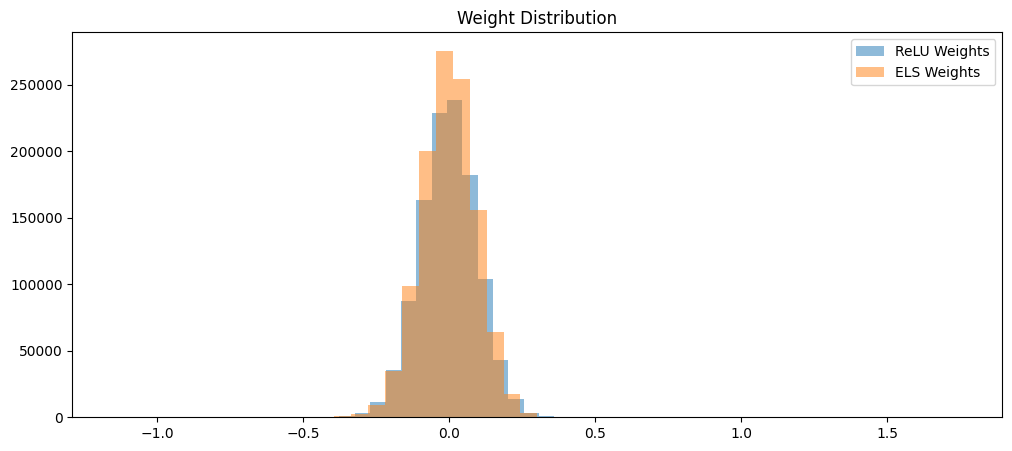

ReLU Model:
Test Accuracy: 0.8307
Sparsity: 0.0001
Total Training Time: 139.59s
ELS Model:
Test Accuracy: 0.8322
Sparsity: 0.0001
Total Training Time: 138.74s


In [8]:


def els(x):
    return tf.where(x>=0, x, x*tf.exp(x))

initializer = tf.keras.initializers.HeNormal()

def build_model(activation_func):
    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)
model_relu.save("model_relu_final.keras")

model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)
model_els.save("model_els_final.keras")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='ELS Train Acc')
plt.plot(history_els.history['val_accuracy'], label='ELS Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')

plt.show()

plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='ELS Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='ELS Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='ELS Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("ELS Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")


In [ ]:
# Visualize feature maps layerwise for both models
def visualize_feature_maps(model, activation_function_name):
    # Choose an image to visualize
    test_image = x_test[0]
    test_image_expanded = np.expand_dims(test_image, axis=0)
    # Get outputs of the convolutional layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    # Get the input tensor from the first layer
    input_img = model.layers[0].input
    # Create a model that will return the outputs given the inputs
    activation_model = Model(inputs=input_img, outputs=layer_outputs)
    activations = activation_model.predict(test_image_expanded)
    # Visualize the feature maps
    for idx, activation in enumerate(activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'{activation_function_name} Activation - Layer {idx+1}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Visualize feature maps for ReLU model
print("\nVisualizing feature maps for ReLU model")
visualize_feature_maps(model_relu, "ReLU")

# Visualize feature maps for ESL model
print("\nVisualizing feature maps for ESL model")
visualize_feature_maps(model_els, "ESL")


# ESL ON MNIST

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ReLU Training:
Epoch 1/100, Time: 28.51s, Loss: 0.1689, Val_Loss: 0.0478, Val_Acc: 0.9844
Epoch 2/100, Time: 26.87s, Loss: 0.0660, Val_Loss: 0.0378, Val_Acc: 0.9886
Epoch 3/100, Time: 4.60s, Loss: 0.0492, Val_Loss: 0.0270, Val_Acc: 0.9920
Epoch 4/100, Time: 4.75s, Loss: 0.0404, Val_Loss: 0.0256, Val_Acc: 0.9914
Epoch 5/100, Time: 5.22s, Loss: 0.0356, Val_Loss: 0.0286, Val_Acc: 0.9914
Epoch 6/100, Time: 4.85s, Loss: 0.0305, Val_Loss: 0.0355, Val_Acc: 0.9886
Epoch 7/100, Time: 5.58s, Loss: 0.0272, Val_Loss: 0.0235, Val_Acc: 0.9922
Epoch 8/100, Time: 4.82s, Loss: 0.0249, Val_Loss: 0.0191, Val_Acc: 0.9942
Epoch 9/100, Time: 4.77s, Loss: 0.0242, Val_Loss: 0.0182, Val_Acc: 0.9938
Epoch 10/100, Time: 5.12s, Loss: 0.0199, Val_Loss: 0.0165, Val_Acc: 0.9950
Epoch 11/100, Time: 4.65s, Loss: 0.0187, Val_Loss: 0.0208, Val_Acc: 0.9948
Epoch 12/100, Time: 6.01s, Loss: 0.0186, Val_Loss: 0.0254, Val_Acc: 0.9936
Epoch 13/100, Time: 4.81s, Loss: 0.0153, 

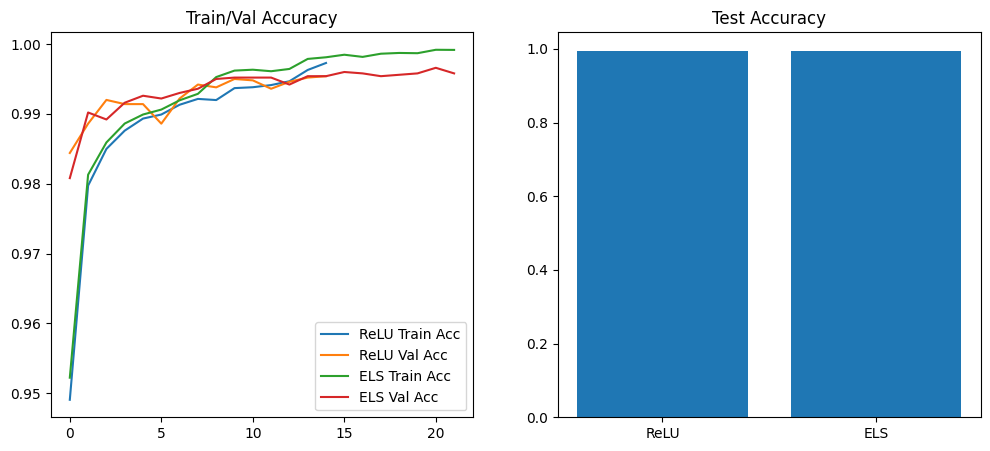

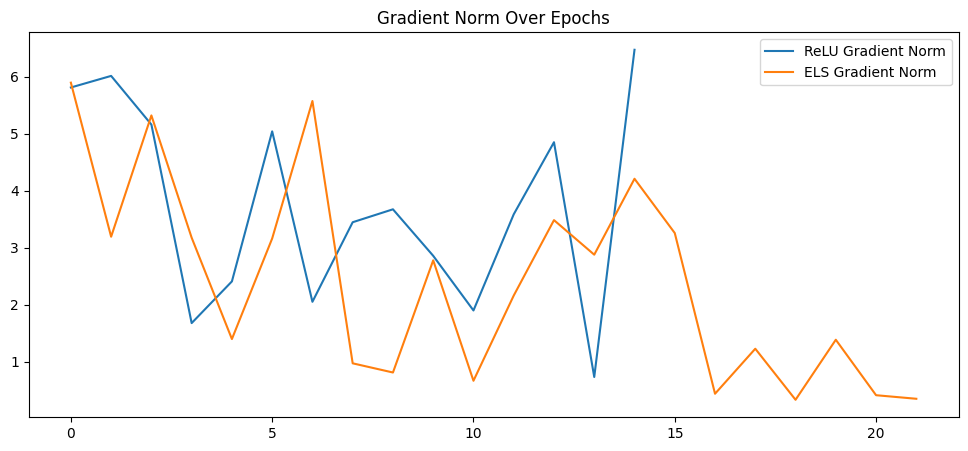

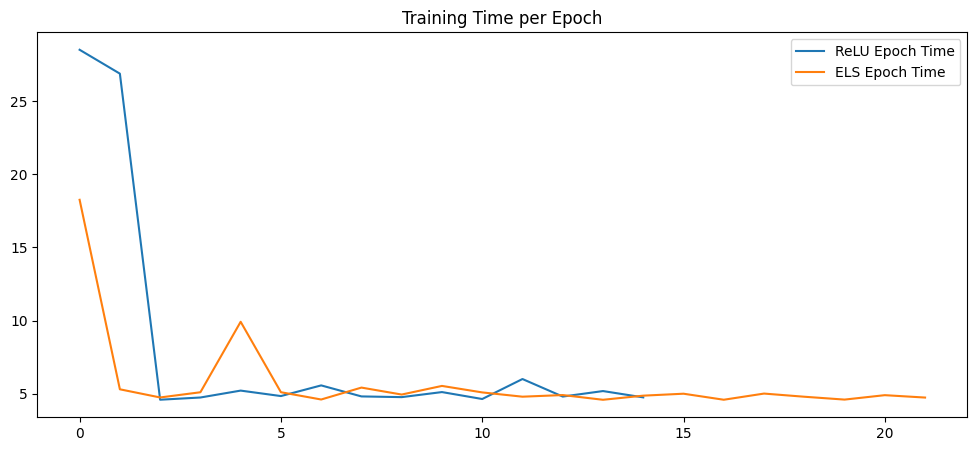

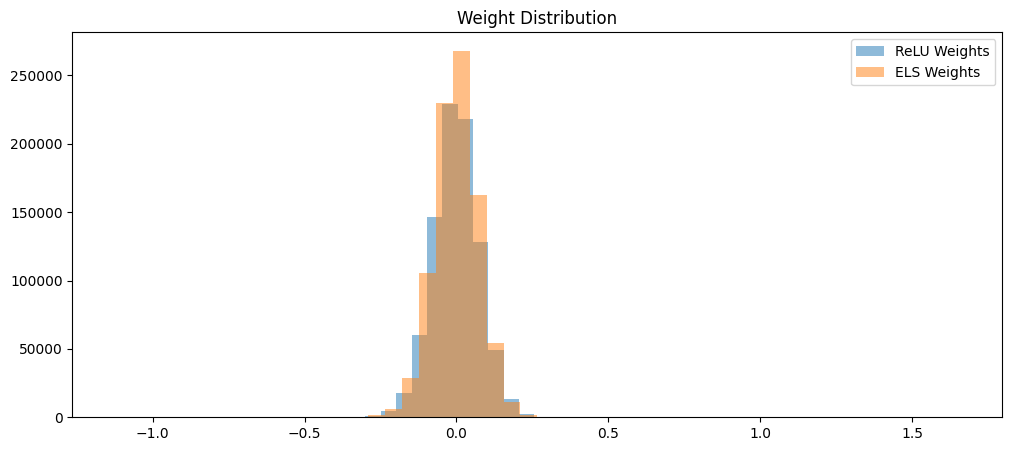

ReLU Model:
Test Accuracy: 0.9951
Sparsity: 0.0002
Total Training Time: 120.50s
ELS Model:
Test Accuracy: 0.9953
Sparsity: 0.0002
Total Training Time: 126.95s


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define ELS activation
def els(x):
    return tf.where(x>=0, x, x*tf.exp(x))

# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for ELS
print("ELS Training:")
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)

model_relu.save("model_relu_final.keras")
model_els.save("model_els_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='ELS Train Acc')
plt.plot(history_els.history['val_accuracy'], label='ELS Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='ELS Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='ELS Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='ELS Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("ELS Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")



Visualizing feature maps for ReLU model
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


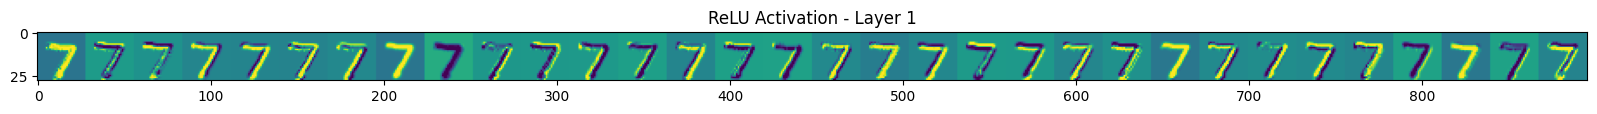

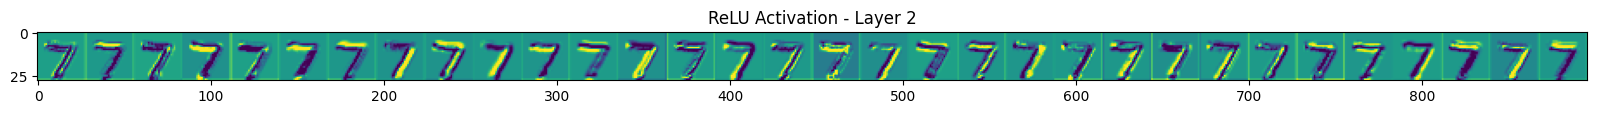

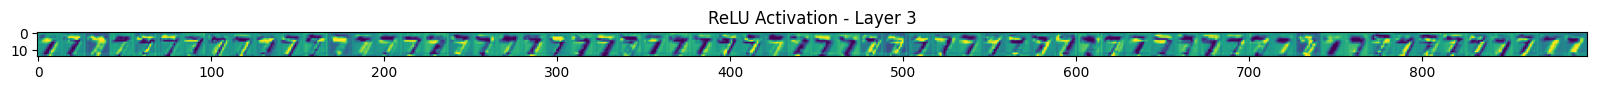

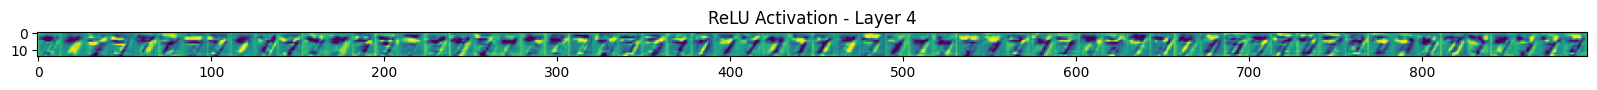


Visualizing feature maps for ELS model
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


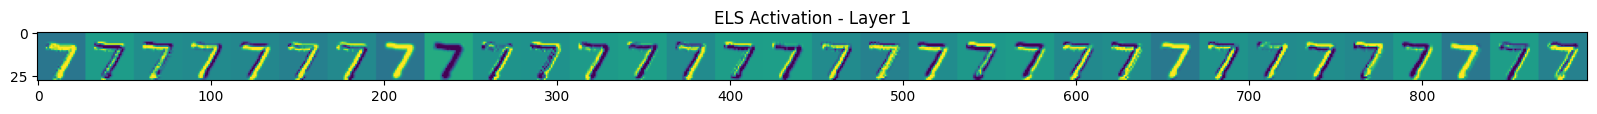

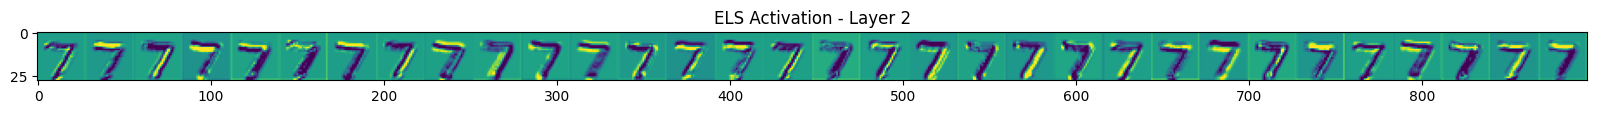

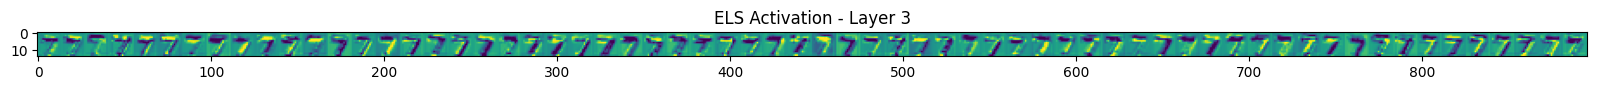

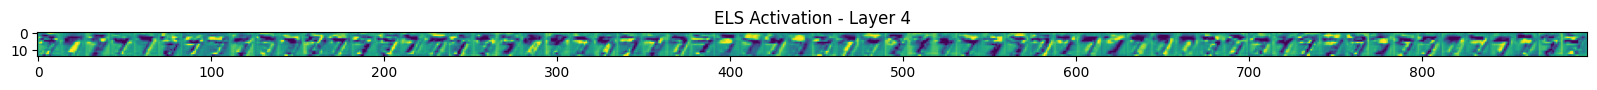

In [4]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model

def visualize_feature_maps(model, activation_function_name, x_test):
    test_image = x_test[0]
    test_image_expanded = np.expand_dims(test_image, axis=0)
    # Extract the outputs of all convolutional layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    # Use model.input instead of model.layers[0].input
    input_img = model.input
    # Create a model that returns the outputs of these layers
    activation_model = Model(inputs=input_img, outputs=layer_outputs)
    activations = activation_model.predict(test_image_expanded)
    # Visualize each feature map
    for idx, activation in enumerate(activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'{activation_function_name} Activation - Layer {idx+1}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Now call the function:
print("\nVisualizing feature maps for ReLU model")
visualize_feature_maps(model_relu, "ReLU", x_test)

print("\nVisualizing feature maps for ELS model")
visualize_feature_maps(model_els, "ELS", x_test)


# Adverserial Attack


Evaluating ReLU model on FGSM adversaries...
functional accuracy on FGSM (eps=0.1) adversarial examples: 0.6420

Evaluating ELS model on FGSM adversaries...
functional_1 accuracy on FGSM (eps=0.1) adversarial examples: 0.5700

Evaluating ReLU model on PGD adversaries...
functional accuracy on PGD (eps=0.1, alpha=0.01, steps=40) adversarial examples: 0.1700

Evaluating ELS model on PGD adversaries...
functional_1 accuracy on PGD (eps=0.1, alpha=0.01, steps=40) adversarial examples: 0.0460


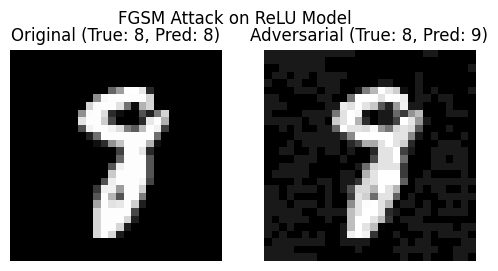

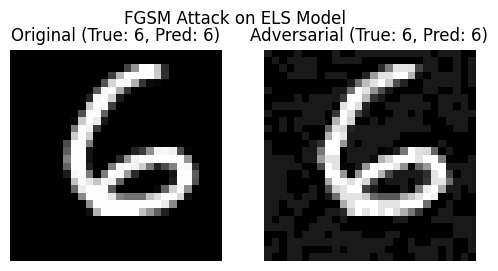

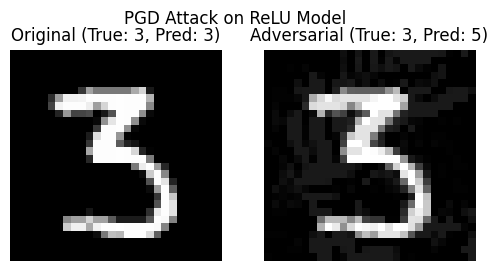

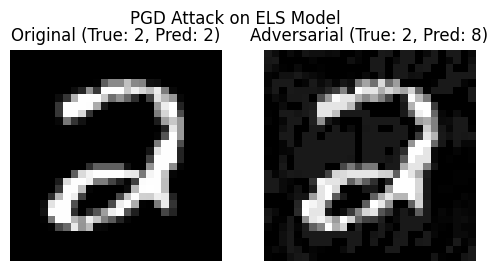

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assume model_relu and model_els are already trained and available
# Assume x_test, y_test are also available (as in the previous code)
# Here we implement FGSM and PGD attacks on a subset of the test data.

# Parameters for attacks
epsilon = 0.1   # For FGSM: Maximum perturbation
pgd_steps = 40   # Number of steps for PGD
pgd_alpha = 0.01 # Step size for PGD
num_samples = 1000  # Number of test samples to evaluate

x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

# Function to perform FGSM attack
def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    # Sign of the gradient
    signed_grads = tf.sign(grads)
    # Add perturbation
    x_adv = x_adv + eps * signed_grads
    # Clip to maintain valid pixel range [0,1]
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

# Function to perform PGD attack
def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        # Project the perturbation onto the L-infinity ball of radius eps
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        # Clip to maintain valid pixel range [0,1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

# Evaluate model on adversarial examples
def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    # Generate adversarial examples
    x_adv = attack_fn(model, x_data, y_data)
    # Evaluate accuracy on adversarial examples
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return x_adv

# Evaluate both models on FGSM adversaries
print("\nEvaluating ReLU model on FGSM adversaries...")
x_adv_relu_fgsm = evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                                          lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                          f"FGSM (eps={epsilon})")

print("\nEvaluating ELS model on FGSM adversaries...")
x_adv_els_fgsm = evaluate_on_adversarial(model_els, x_test_subset, y_test_subset,
                                         lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                         f"FGSM (eps={epsilon})")

# Evaluate both models on PGD adversaries
print("\nEvaluating ReLU model on PGD adversaries...")
x_adv_relu_pgd = evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                                         lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                         f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

print("\nEvaluating ELS model on PGD adversaries...")
x_adv_els_pgd = evaluate_on_adversarial(model_els, x_test_subset, y_test_subset,
                                        lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                        f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

# Visualize some adversarial examples
def visualize_adversarial_examples(x_orig, x_adv, y_true, model, title):
    idx = np.random.randint(0, len(x_orig))
    orig_image = x_orig[idx]
    adv_image = x_adv[idx]
    true_label = np.argmax(y_true[idx])
    pred_orig = np.argmax(model.predict(np.expand_dims(orig_image,0), verbose=0))
    pred_adv = np.argmax(model.predict(np.expand_dims(adv_image,0), verbose=0))

    # Ensure numpy arrays
    if isinstance(orig_image, tf.Tensor):
        orig_image = orig_image.numpy()
    if isinstance(adv_image, tf.Tensor):
        adv_image = adv_image.numpy()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title(f"Original (True: {true_label}, Pred: {pred_orig})")
    # If shape is (28,28,1), display the first channel
    plt.imshow(orig_image[...,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Adversarial (True: {true_label}, Pred: {pred_adv})")
    plt.imshow(adv_image[...,0], cmap='gray')
    plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Visualize for FGSM (ReLU)
visualize_adversarial_examples(x_test_subset, x_adv_relu_fgsm, y_test_subset, model_relu, "FGSM Attack on ReLU Model")

# Visualize for FGSM (ELS)
visualize_adversarial_examples(x_test_subset, x_adv_els_fgsm, y_test_subset, model_els, "FGSM Attack on ELS Model")

# Visualize for PGD (ReLU)
visualize_adversarial_examples(x_test_subset, x_adv_relu_pgd, y_test_subset, model_relu, "PGD Attack on ReLU Model")

# Visualize for PGD (ELS)
visualize_adversarial_examples(x_test_subset, x_adv_els_pgd, y_test_subset, model_els, "PGD Attack on ELS Model")


# Gradient Flow

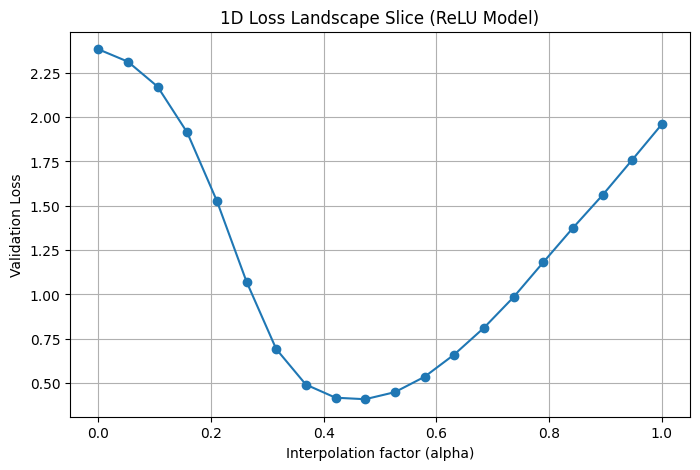

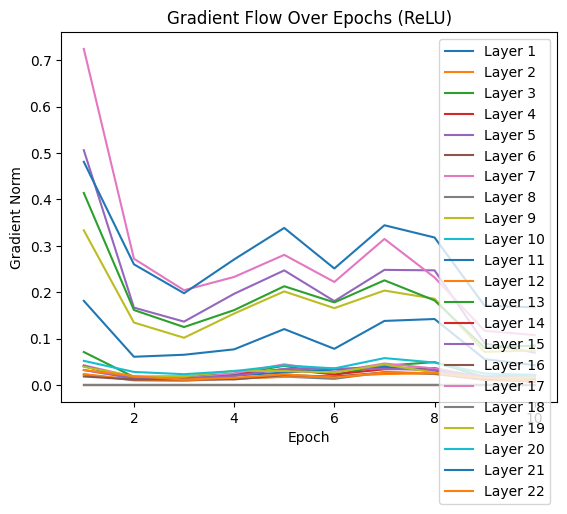

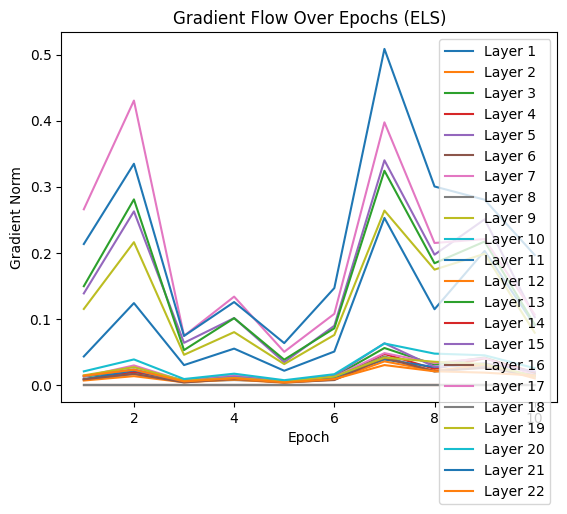

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.initializers import HeNormal

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
tf.random.set_seed(42)
np.random.seed(42)
batch_size = 64
learning_rate = 0.001
epochs = 10
num_classes = 10
val_size = 5000

# -------------------------------------------------------------
# Data Loading and Preparation (MNIST)
# -------------------------------------------------------------
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_train_full = to_categorical(y_train_full, num_classes)
y_test = to_categorical(y_test, num_classes)
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# -------------------------------------------------------------
# Define ELS Activation Function
# -------------------------------------------------------------
def els(x):
    return tf.where(x>=0, x, x*tf.exp(x))

# -------------------------------------------------------------
# Model Builder
# -------------------------------------------------------------
initializer = HeNormal()
def build_model(activation_func):
    inputs = Input(shape=(28,28,1))
    x = Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(256, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# -------------------------------------------------------------
# Custom Callback for Gradient Flow Analysis
# -------------------------------------------------------------
class GradientFlowCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_layer_grad_norms = []

    def on_epoch_end(self, epoch, logs=None):
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
            loss_value = tf.reduce_mean(loss_value)
        grads = tape.gradient(loss_value, self.model.trainable_variables)

        var_layer_names = [var.name.split('/')[0] for var in self.model.trainable_variables]
        layer_norms = []
        current_layer = var_layer_names[0]
        current_grads = []

        for g, lname in zip(grads, var_layer_names):
            if lname != current_layer:
                if current_grads:
                    layer_norms.append(np.mean([np.linalg.norm(g_.numpy()) for g_ in current_grads if g_ is not None]))
                current_layer = lname
                current_grads = [g]
            else:
                current_grads.append(g)
        if current_grads:
            layer_norms.append(np.mean([np.linalg.norm(g_.numpy()) for g_ in current_grads if g_ is not None]))

        self.epoch_layer_grad_norms.append(layer_norms)

# -------------------------------------------------------------
# Train ReLU model
# -------------------------------------------------------------
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy', metrics=['accuracy'])

grad_flow_cb_relu = GradientFlowCallback()
model_relu.fit(x_train, y_train, validation_data=(x_val, y_val),
               epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[grad_flow_cb_relu])

# -------------------------------------------------------------
# Train ELS model
# -------------------------------------------------------------
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])

grad_flow_cb_els = GradientFlowCallback()
model_els.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[grad_flow_cb_els])

# -------------------------------------------------------------
# Loss Landscape Analysis (1D Slice)
# -------------------------------------------------------------
def get_weights(model):
    return [w.numpy() for w in model.trainable_variables]

def set_weights(model, weights):
    for w, val in zip(model.trainable_variables, weights):
        w.assign(val)

model_for_landscape = build_model('relu')
model_for_landscape.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                            loss='categorical_crossentropy', metrics=['accuracy'])

initial_weights = get_weights(model_for_landscape)
final_weights = get_weights(model_relu)

num_points = 20
alphas = np.linspace(0, 1, num_points)
losses = []
for alpha in alphas:
    interp_weights = [(1 - alpha)*i_w + alpha*f_w for i_w, f_w in zip(initial_weights, final_weights)]
    set_weights(model_for_landscape, interp_weights)
    val_preds = model_for_landscape.predict(x_val, verbose=0)
    val_loss = tf.keras.losses.categorical_crossentropy(y_val, val_preds)
    val_loss = tf.reduce_mean(val_loss).numpy()
    losses.append(val_loss)

plt.figure(figsize=(8,5))
plt.plot(alphas, losses, marker='o')
plt.title('1D Loss Landscape Slice (ReLU Model)')
plt.xlabel('Interpolation factor (alpha)')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# Gradient Flow Analysis Visualization
# -------------------------------------------------------------
relu_grad_norms = grad_flow_cb_relu.epoch_layer_grad_norms
els_grad_norms = grad_flow_cb_els.epoch_layer_grad_norms

def plot_gradient_flow(grad_norms, title):
    max_layers = max(len(g) for g in grad_norms)
    grad_norms = np.array([np.pad(g, (0,max_layers-len(g)), 'constant', constant_values=np.nan) for g in grad_norms])
    for layer_idx in range(max_layers):
        plt.plot(range(1, len(grad_norms)+1), grad_norms[:, layer_idx], label=f'Layer {layer_idx+1}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.show()

plot_gradient_flow(relu_grad_norms, 'Gradient Flow Over Epochs (ReLU)')
plot_gradient_flow(els_grad_norms, 'Gradient Flow Over Epochs (ELS)')


# Deeper Model

Epoch 1/20, Time: 17.86s, Loss: 0.1672, Val_Loss: 0.0491, Val_Acc: 0.9860
Epoch 2/20, Time: 10.80s, Loss: 0.0644, Val_Loss: 0.0356, Val_Acc: 0.9894
Epoch 3/20, Time: 5.29s, Loss: 0.0484, Val_Loss: 0.0296, Val_Acc: 0.9926
Epoch 4/20, Time: 4.84s, Loss: 0.0410, Val_Loss: 0.0267, Val_Acc: 0.9920
Epoch 5/20, Time: 5.14s, Loss: 0.0361, Val_Loss: 0.0342, Val_Acc: 0.9910
Epoch 6/20, Time: 4.99s, Loss: 0.0309, Val_Loss: 0.0272, Val_Acc: 0.9922
Epoch 7/20, Time: 4.57s, Loss: 0.0289, Val_Loss: 0.0254, Val_Acc: 0.9928
Epoch 8/20, Time: 5.14s, Loss: 0.0253, Val_Loss: 0.0239, Val_Acc: 0.9924
Epoch 9/20, Time: 10.00s, Loss: 0.0219, Val_Loss: 0.0242, Val_Acc: 0.9930
Epoch 10/20, Time: 4.76s, Loss: 0.0232, Val_Loss: 0.0222, Val_Acc: 0.9934
Epoch 11/20, Time: 4.81s, Loss: 0.0196, Val_Loss: 0.0218, Val_Acc: 0.9932
Epoch 12/20, Time: 4.99s, Loss: 0.0177, Val_Loss: 0.0201, Val_Acc: 0.9938
Epoch 13/20, Time: 4.81s, Loss: 0.0159, Val_Loss: 0.0194, Val_Acc: 0.9934
Epoch 14/20, Time: 4.97s, Loss: 0.0149, Val_

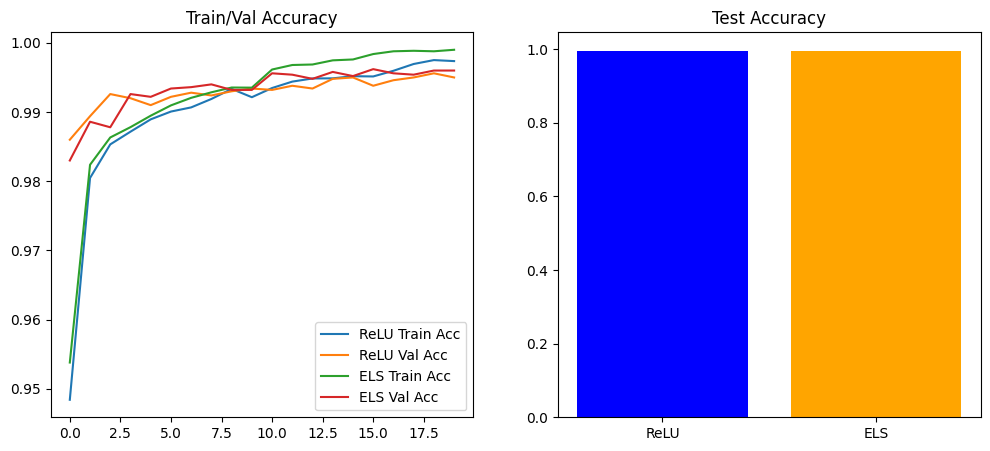

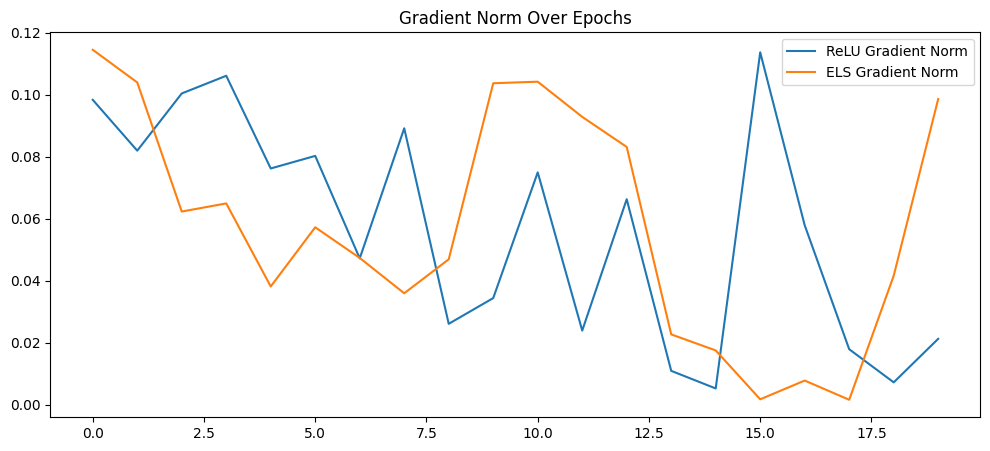

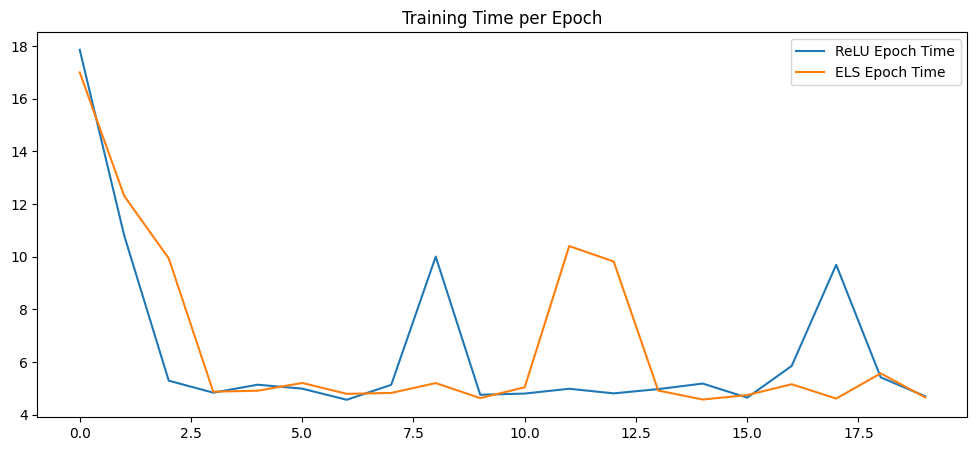

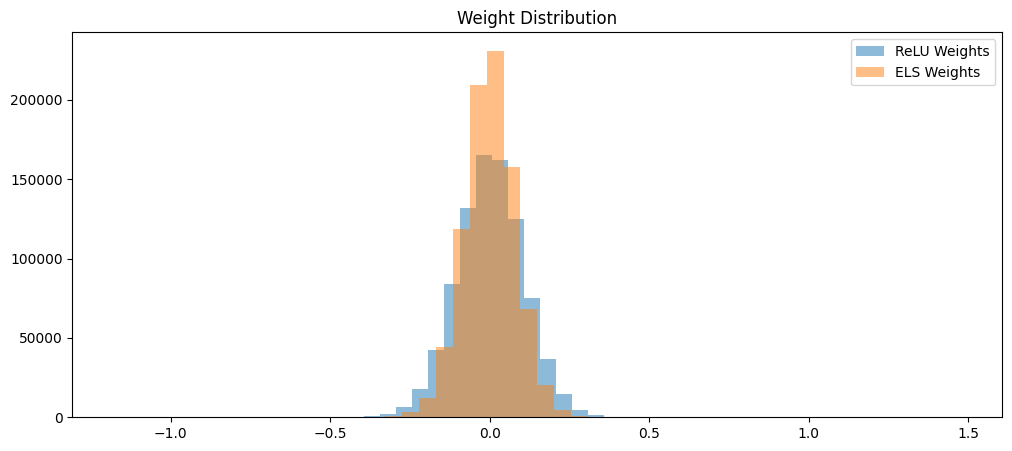

ReLU Model:
Test Accuracy: 0.9952
Sparsity: 0.0001
Total Training Time: 128.49s
ELS Model:
Test Accuracy: 0.9956
Sparsity: 0.0002
Total Training Time: 133.23s


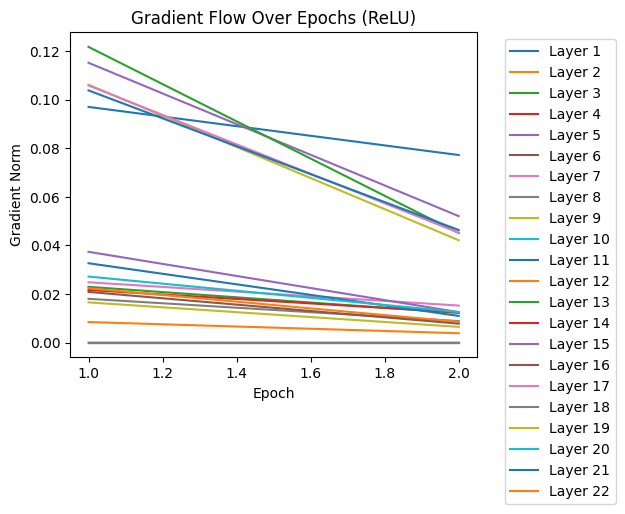

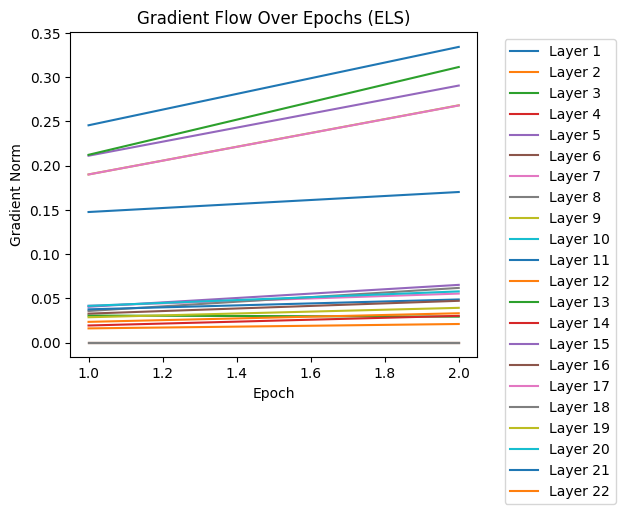

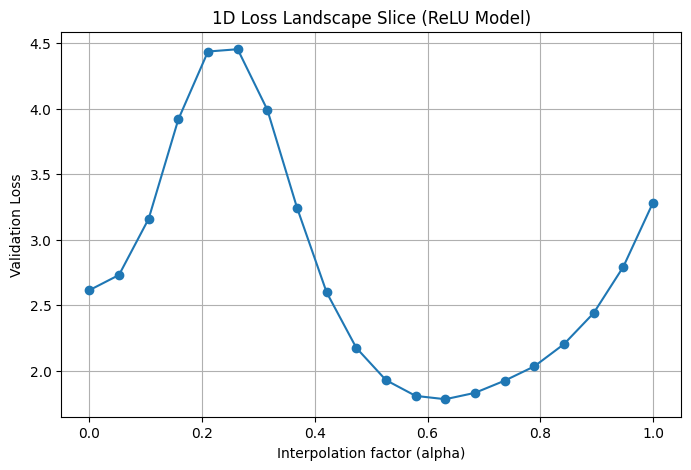


Training Deeper/Wider ReLU Model...
Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8456 - loss: 0.4815 - val_accuracy: 0.9852 - val_loss: 0.0460
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9793 - loss: 0.0683 - val_accuracy: 0.9894 - val_loss: 0.0364
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9834 - loss: 0.0529 - val_accuracy: 0.9878 - val_loss: 0.0431
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9872 - loss: 0.0416 - val_accuracy: 0.9900 - val_loss: 0.0323
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9887 - loss: 0.0363 - val_accuracy: 0.9928 - val_loss: 0.0233
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9904 - loss: 0.0313 - val_accuracy: 0.9912 - val_loss: 0.0336
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9894 - loss: 0.0324 - val_accuracy: 0.9918 - val_loss: 0.0289
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accur

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.initializers import HeNormal
import copy

# -------------------------------------------------------------
# Set seeds for reproducibility
# -------------------------------------------------------------
tf.random.set_seed(42)
np.random.seed(42)

# -------------------------------------------------------------
# Hyperparameters
# -------------------------------------------------------------
batch_size = 64
learning_rate = 0.001
epochs = 20
num_classes = 10
val_size = 5000

# -------------------------------------------------------------
# Load and Prepare MNIST Data (No Data Augmentation)
# -------------------------------------------------------------
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_train_full = to_categorical(y_train_full, num_classes)
y_test = to_categorical(y_test, num_classes)

x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# -------------------------------------------------------------
# Define ELS Activation Function
# -------------------------------------------------------------
def els(x):
    return tf.where(x >= 0, x, x * tf.exp(x))

# -------------------------------------------------------------
# Model Builder (Standard Depth)
# -------------------------------------------------------------
initializer = HeNormal()

def build_model(activation_func):
    inputs = Input(shape=(28,28,1))
    x = Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(256, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# -------------------------------------------------------------
# Custom Callback for Timing and Gradient Norm Tracking
# -------------------------------------------------------------
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time

        # Compute gradient norm
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
            loss_value = tf.reduce_mean(loss_value)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)

        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# -------------------------------------------------------------
# Compute Sparsity
# -------------------------------------------------------------
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# -------------------------------------------------------------
# Train with ReLU
# -------------------------------------------------------------
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)
model_relu.save("model_relu_final.keras")

# -------------------------------------------------------------
# Train with ELS
# -------------------------------------------------------------
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)
model_els.save("model_els_final.keras")

# -------------------------------------------------------------
# Plot Accuracy
# -------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='ELS Train Acc')
plt.plot(history_els.history['val_accuracy'], label='ELS Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els], color=['blue', 'orange'])
plt.title('Test Accuracy')
plt.show()

# -------------------------------------------------------------
# Plot Gradient Norms Over Epochs
# -------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='ELS Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# -------------------------------------------------------------
# Plot Training Times per Epoch
# -------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='ELS Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# -------------------------------------------------------------
# Weight Distributions
# -------------------------------------------------------------
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='ELS Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

# -------------------------------------------------------------
# Print Summary Results
# -------------------------------------------------------------
print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("ELS Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")

# -------------------------------------------------------------
# Gradient Flow Analysis Class
# -------------------------------------------------------------
class GradientFlowCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_train, y_train, batch_size=64):
        super().__init__()
        self.epoch_layer_grad_norms = []
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        x_sample, y_sample = self.x_train[:self.batch_size], self.y_train[:self.batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
            loss_value = tf.reduce_mean(loss_value)
        grads = tape.gradient(loss_value, self.model.trainable_variables)

        var_layer_names = [var.name.split('/')[0] for var in self.model.trainable_variables]
        layer_norms = []
        current_layer = var_layer_names[0]
        current_grads = []

        for g, lname in zip(grads, var_layer_names):
            if lname != current_layer:
                if current_grads:
                    layer_norms.append(np.mean([np.linalg.norm(g_.numpy()) for g_ in current_grads if g_ is not None]))
                current_layer = lname
                current_grads = [g]
            else:
                current_grads.append(g)
        if current_grads:
            layer_norms.append(np.mean([np.linalg.norm(g_.numpy()) for g_ in current_grads if g_ is not None]))

        self.epoch_layer_grad_norms.append(layer_norms)

# -------------------------------------------------------------
# Gradient Flow Analysis for ReLU and ELS Models (Original)
# -------------------------------------------------------------
grad_flow_cb_relu = GradientFlowCallback(x_train, y_train, batch_size=batch_size)
model_relu.fit(x_train, y_train, epochs=2, batch_size=batch_size, verbose=0, callbacks=[grad_flow_cb_relu])
relu_grad_norms = grad_flow_cb_relu.epoch_layer_grad_norms

grad_flow_cb_els = GradientFlowCallback(x_train, y_train, batch_size=batch_size)
model_els.fit(x_train, y_train, epochs=2, batch_size=batch_size, verbose=0, callbacks=[grad_flow_cb_els])
els_grad_norms = grad_flow_cb_els.epoch_layer_grad_norms

def plot_gradient_flow(grad_norms, title):
    max_layers = max(len(g) for g in grad_norms)
    grad_norms = np.array([np.pad(g, (0,max_layers-len(g)), 'constant', constant_values=np.nan) for g in grad_norms])
    for layer_idx in range(max_layers):
        plt.plot(range(1, len(grad_norms)+1), grad_norms[:, layer_idx], label=f'Layer {layer_idx+1}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_gradient_flow(relu_grad_norms, 'Gradient Flow Over Epochs (ReLU)')
plot_gradient_flow(els_grad_norms, 'Gradient Flow Over Epochs (ELS)')

# -------------------------------------------------------------
# Loss Landscape Analysis (1D Slice) for ReLU Model
# -------------------------------------------------------------
def get_weights(model):
    return [w.numpy() for w in model.trainable_variables]

def set_weights(model, weights):
    for w, val in zip(model.trainable_variables, weights):
        w.assign(val)

# Make a new model with same architecture for interpolation
model_for_landscape = build_model('relu')
model_for_landscape.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                            loss='categorical_crossentropy', metrics=['accuracy'])
initial_weights = get_weights(model_for_landscape)
final_weights = get_weights(model_relu)

num_points = 20
alphas = np.linspace(0, 1, num_points)
losses = []
for alpha in alphas:
    interp_weights = [(1 - alpha)*i_w + alpha*f_w for i_w, f_w in zip(initial_weights, final_weights)]
    set_weights(model_for_landscape, interp_weights)
    val_preds = model_for_landscape.predict(x_val, verbose=0)
    val_loss = tf.keras.losses.categorical_crossentropy(y_val, val_preds)
    val_loss = tf.reduce_mean(val_loss).numpy()
    losses.append(val_loss)

plt.figure(figsize=(8,5))
plt.plot(alphas, losses, marker='o')
plt.title('1D Loss Landscape Slice (ReLU Model)')
plt.xlabel('Interpolation factor (alpha)')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# Deeper or Wider Networks:
# Build a deeper/wider model and compare ReLU vs ELS
# -------------------------------------------------------------
def build_deeper_model(activation_func, depth_factor=3):
    # depth_factor controls how many times we repeat a block pattern
    # Each block: (Conv->BN->Act)*2 -> MaxPool -> Dropout
    # Filters double each block
    inputs = Input(shape=(28,28,1))
    x = inputs
    filters = 32
    for d in range(depth_factor):
        x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_func)(x)
        x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_func)(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.25)(x)
        filters *= 2

    x = Flatten()(x)
    x = Dense(512, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

def train_and_evaluate_deeper(activation_func, name, depth_factor=3, epochs_deeper=10):
    model = build_deeper_model(activation_func, depth_factor=depth_factor)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs_deeper,
                        batch_size=batch_size,
                        verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{name} Deeper Model Test Accuracy: {test_acc:.4f}")
    return model, history, test_acc

print("\nTraining Deeper/Wider ReLU Model...")
model_relu_deep, history_relu_deep, acc_relu_deep = train_and_evaluate_deeper('relu', "ReLU", depth_factor=3, epochs_deeper=10)

print("\nTraining Deeper/Wider ELS Model...")
model_els_deep, history_els_deep, acc_els_deep = train_and_evaluate_deeper(els, "ELS", depth_factor=3, epochs_deeper=10)

# Compare their accuracies on deeper model
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu_deep.history['accuracy'], label='ReLU Deep Train Acc')
plt.plot(history_relu_deep.history['val_accuracy'], label='ReLU Deep Val Acc')
plt.plot(history_els_deep.history['accuracy'], label='ELS Deep Train Acc')
plt.plot(history_els_deep.history['val_accuracy'], label='ELS Deep Val Acc')
plt.title('Deeper Model Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU Deep', 'ELS Deep'], [acc_relu_deep, acc_els_deep], color=['blue', 'orange'])
plt.title('Deeper Model Test Accuracy')
plt.show()

print("Done. The code included:")
print("- Baseline training with ReLU and ELS (original model)")
print("- Tracking training time, gradient norms, accuracy, sparsity")
print("- Visualization of accuracy, gradient norms, weight distributions")
print("- Loss landscape 1D slice (for ReLU model)")
print("- Gradient flow analysis")
print("- Deeper/Wider model training comparison for ReLU vs ELS")



Training Deeper/Wider ReLU Model...
Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8497 - loss: 0.4657 - val_accuracy: 0.9858 - val_loss: 0.0442
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9775 - loss: 0.0705 - val_accuracy: 0.9902 - val_loss: 0.0343
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9853 - loss: 0.0482 - val_accuracy: 0.9902 - val_loss: 0.0350
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9877 - loss: 0.0406 - val_accuracy: 0.9918 - val_loss: 0.0282
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9886 - loss: 0.0367 - val_accuracy: 0.9898 - val_loss: 0.0368
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9904 - loss: 0.0319 - val_accuracy: 0.9934 - val_loss: 0.0265
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9913 - loss: 0.0284 - val_accuracy: 0.9906 - val_loss: 0.0326
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy

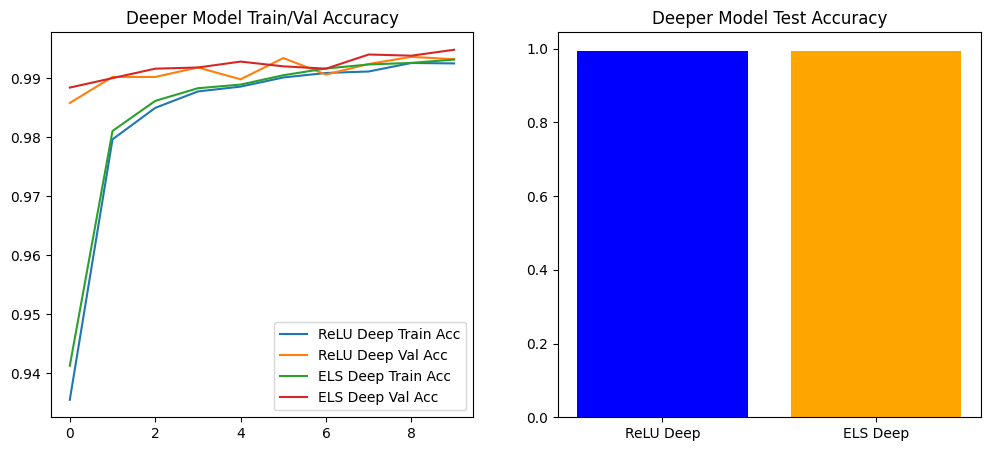

Done. The code included:
- Baseline training with ReLU and ELS (original model)
- Tracking training time, gradient norms, accuracy, sparsity
- Visualization of accuracy, gradient norms, weight distributions
- Loss landscape 1D slice (for ReLU model)
- Gradient flow analysis
- Deeper/Wider model training comparison for ReLU vs ELS


In [10]:
# -------------------------------------------------------------
# Deeper or Wider Networks:
# Build a deeper/wider model and compare ReLU vs ELS
# -------------------------------------------------------------
def build_deeper_model(activation_func, depth_factor=3):
    # depth_factor controls how many times we repeat a block pattern
    # Each block: (Conv->BN->Act)*2 -> MaxPool -> Dropout
    # Filters double each block
    inputs = Input(shape=(28,28,1))
    x = inputs
    filters = 32
    for d in range(depth_factor):
        x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_func)(x)
        x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_func)(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.25)(x)
        filters *= 2

    x = Flatten()(x)
    x = Dense(512, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

def train_and_evaluate_deeper(activation_func, name, depth_factor=3, epochs_deeper=10):
    model = build_deeper_model(activation_func, depth_factor=depth_factor)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs_deeper,
                        batch_size=batch_size,
                        verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{name} Deeper Model Test Accuracy: {test_acc:.4f}")
    return model, history, test_acc

print("\nTraining Deeper/Wider ReLU Model...")
model_relu_deep, history_relu_deep, acc_relu_deep = train_and_evaluate_deeper('relu', "ReLU", depth_factor=3, epochs_deeper=10)

print("\nTraining Deeper/Wider ELS Model...")
model_els_deep, history_els_deep, acc_els_deep = train_and_evaluate_deeper(els, "ELS", depth_factor=3, epochs_deeper=10)

# Compare their accuracies on deeper model
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu_deep.history['accuracy'], label='ReLU Deep Train Acc')
plt.plot(history_relu_deep.history['val_accuracy'], label='ReLU Deep Val Acc')
plt.plot(history_els_deep.history['accuracy'], label='ELS Deep Train Acc')
plt.plot(history_els_deep.history['val_accuracy'], label='ELS Deep Val Acc')
plt.title('Deeper Model Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU Deep', 'ELS Deep'], [acc_relu_deep, acc_els_deep], color=['blue', 'orange'])
plt.title('Deeper Model Test Accuracy')
plt.show()

print("Done. The code included:")
print("- Baseline training with ReLU and ELS (original model)")
print("- Tracking training time, gradient norms, accuracy, sparsity")
print("- Visualization of accuracy, gradient norms, weight distributions")
print("- Loss landscape 1D slice (for ReLU model)")
print("- Gradient flow analysis")
print("- Deeper/Wider model training comparison for ReLU vs ELS")

# Quadratic activation

ReLU Training:
Epoch 1/100, Time: 15.50s, Loss: 0.1711, Val_Loss: 0.0446, Val_Acc: 0.9862
Epoch 2/100, Time: 4.98s, Loss: 0.0642, Val_Loss: 0.0308, Val_Acc: 0.9906
Epoch 3/100, Time: 5.02s, Loss: 0.0497, Val_Loss: 0.0310, Val_Acc: 0.9912
Epoch 4/100, Time: 4.79s, Loss: 0.0414, Val_Loss: 0.0271, Val_Acc: 0.9922
Epoch 5/100, Time: 5.33s, Loss: 0.0358, Val_Loss: 0.0239, Val_Acc: 0.9928
Epoch 6/100, Time: 5.07s, Loss: 0.0306, Val_Loss: 0.0247, Val_Acc: 0.9926
Epoch 7/100, Time: 4.75s, Loss: 0.0283, Val_Loss: 0.0362, Val_Acc: 0.9898
Epoch 8/100, Time: 5.28s, Loss: 0.0239, Val_Loss: 0.0227, Val_Acc: 0.9934
Epoch 9/100, Time: 4.70s, Loss: 0.0223, Val_Loss: 0.0231, Val_Acc: 0.9928
Epoch 10/100, Time: 4.75s, Loss: 0.0211, Val_Loss: 0.0233, Val_Acc: 0.9938
Epoch 11/100, Time: 5.63s, Loss: 0.0213, Val_Loss: 0.0197, Val_Acc: 0.9944
Epoch 12/100, Time: 10.99s, Loss: 0.0181, Val_Loss: 0.0193, Val_Acc: 0.9942
Epoch 13/100, Time: 5.34s, Loss: 0.0159, Val_Loss: 0.0200, Val_Acc: 0.9946
Epoch 14/100, Tim

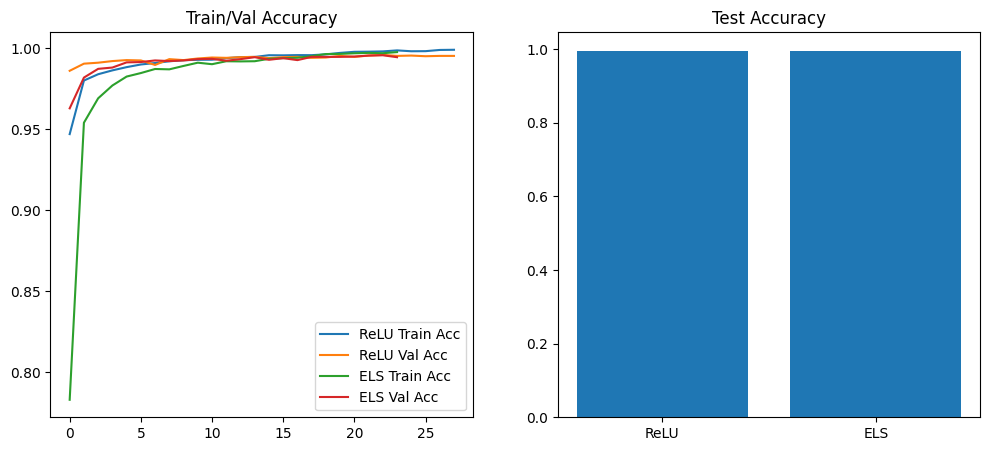

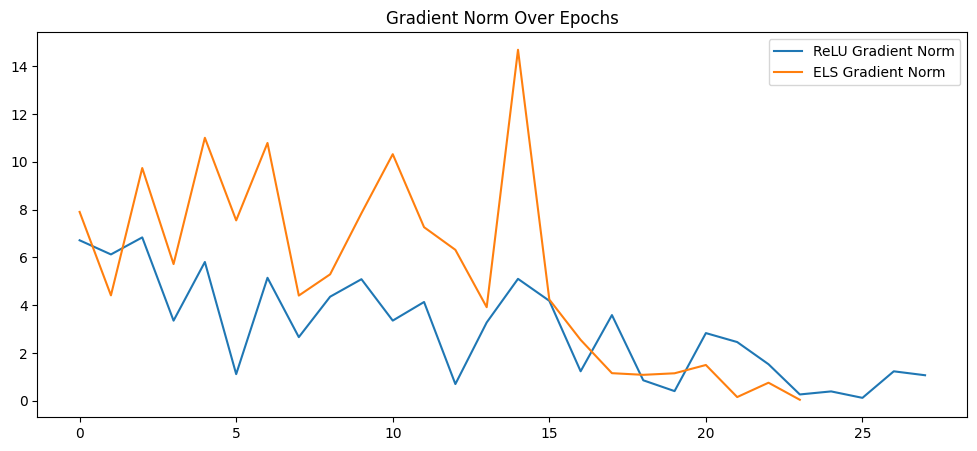

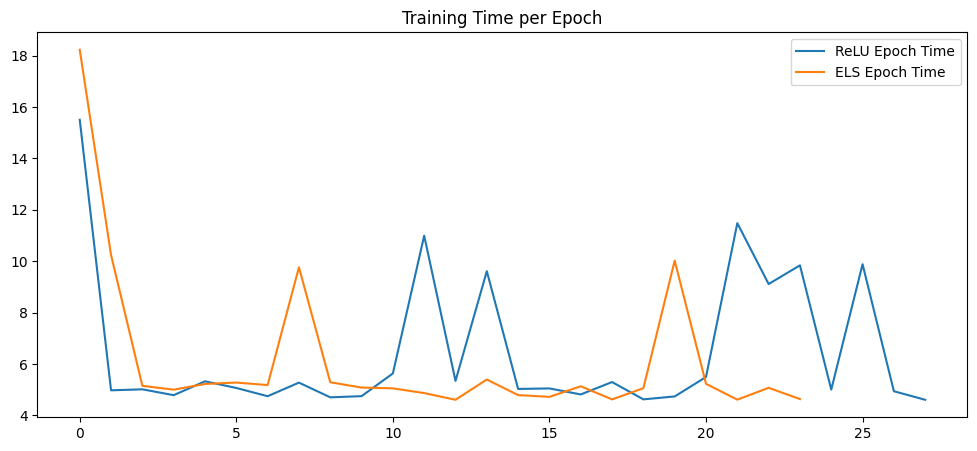

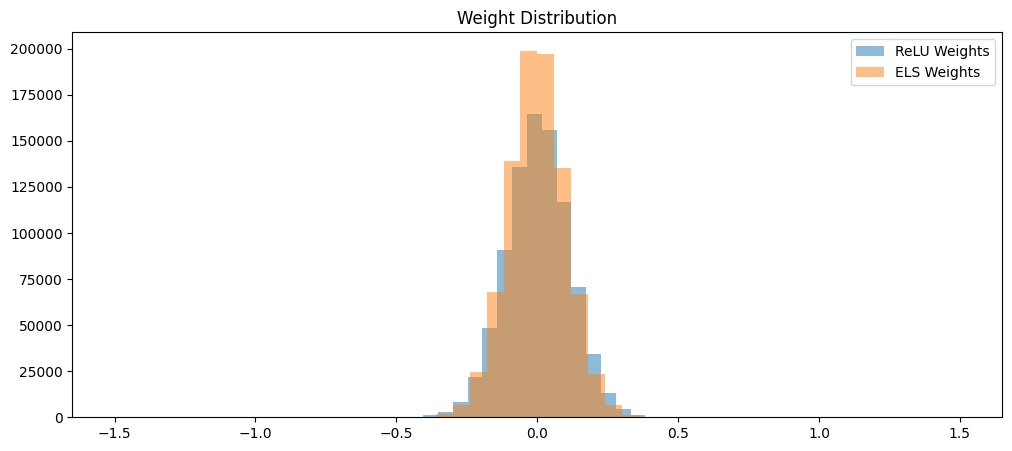

ReLU Model:
Test Accuracy: 0.9960
Sparsity: 0.0001
Total Training Time: 181.66s
ELS Model:
Test Accuracy: 0.9957
Sparsity: 0.0002
Total Training Time: 148.27s


In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define ELS activation
def els(x):
    a, b, c = 0.5, 0.0, 0.0  # Example coefficients
    return a * tf.square(x) + b * x + c

# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for ELS
print("ELS Training:")
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)

model_relu.save("model_relu_final.keras")
model_els.save("model_els_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='ELS Train Acc')
plt.plot(history_els.history['val_accuracy'], label='ELS Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='ELS Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='ELS Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='ELS Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("ELS Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")


## Quantum Hyperbolic Activation

ReLU Training:
Epoch 1/100, Time: 15.74s, Loss: 0.1669, Val_Loss: 0.0435, Val_Acc: 0.9874
Epoch 2/100, Time: 12.17s, Loss: 0.0638, Val_Loss: 0.0352, Val_Acc: 0.9894
Epoch 3/100, Time: 5.18s, Loss: 0.0501, Val_Loss: 0.0318, Val_Acc: 0.9908
Epoch 4/100, Time: 4.84s, Loss: 0.0400, Val_Loss: 0.0275, Val_Acc: 0.9904
Epoch 5/100, Time: 5.15s, Loss: 0.0355, Val_Loss: 0.0239, Val_Acc: 0.9930
Epoch 6/100, Time: 4.86s, Loss: 0.0306, Val_Loss: 0.0251, Val_Acc: 0.9924
Epoch 7/100, Time: 4.60s, Loss: 0.0276, Val_Loss: 0.0254, Val_Acc: 0.9926
Epoch 8/100, Time: 7.19s, Loss: 0.0249, Val_Loss: 0.0187, Val_Acc: 0.9950
Epoch 9/100, Time: 4.68s, Loss: 0.0219, Val_Loss: 0.0186, Val_Acc: 0.9940
Epoch 10/100, Time: 5.57s, Loss: 0.0196, Val_Loss: 0.0173, Val_Acc: 0.9948
Epoch 11/100, Time: 10.04s, Loss: 0.0191, Val_Loss: 0.0207, Val_Acc: 0.9936
Epoch 12/100, Time: 4.75s, Loss: 0.0187, Val_Loss: 0.0228, Val_Acc: 0.9930
Epoch 13/100, Time: 5.08s, Loss: 0.0157, Val_Loss: 0.0231, Val_Acc: 0.9932
Epoch 14/100, Ti

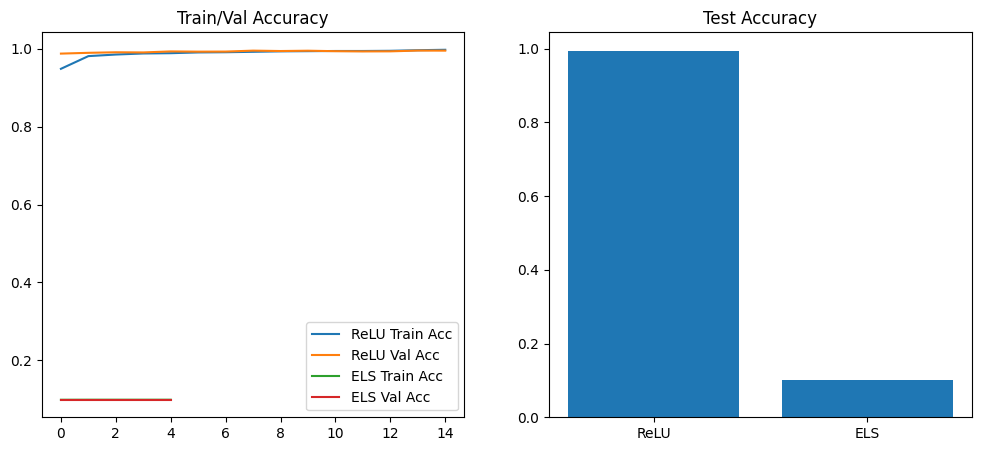

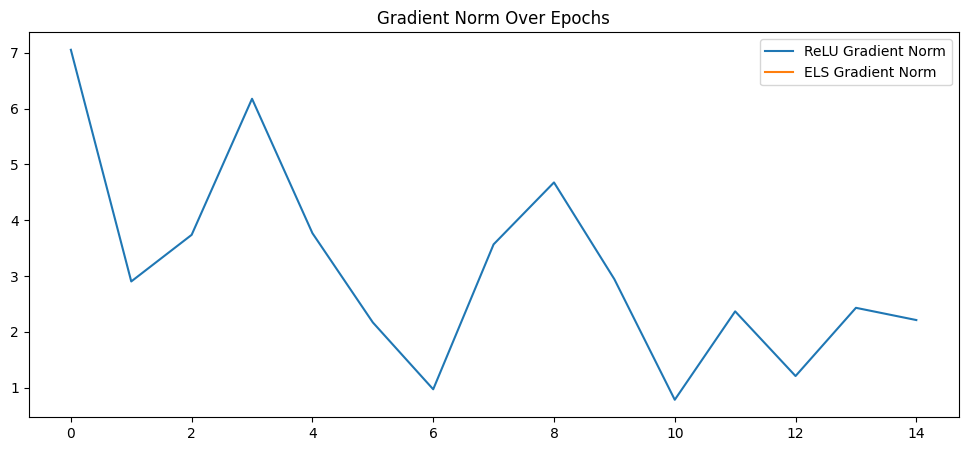

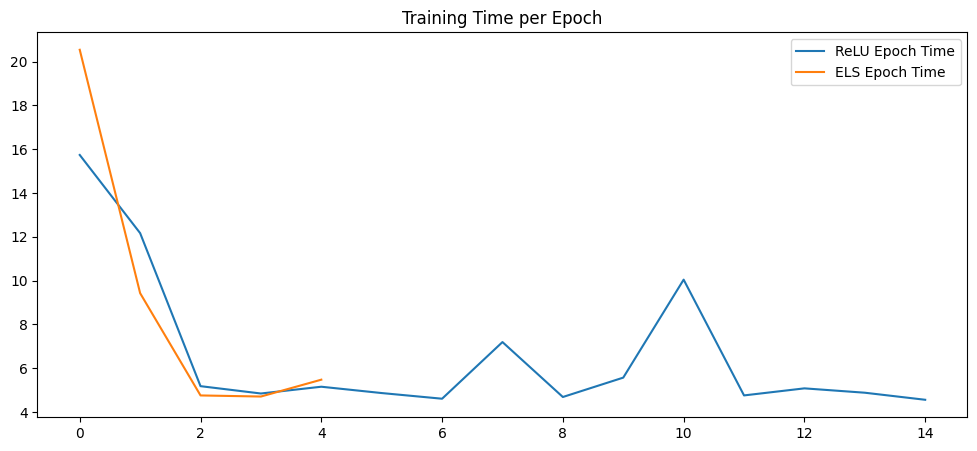

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

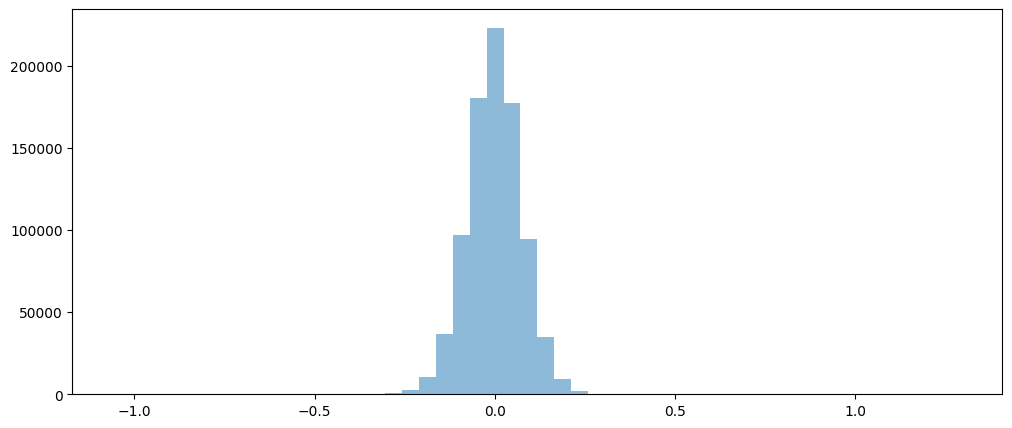

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define ELS activation
def els(x):
    alpha = 1.0
    beta = 0.1  # Example coefficients
    return 0.5 * (tf.exp(alpha * x) - tf.exp(-alpha * x)) * tf.sign(x) + beta * x


# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for ELS
print("ELS Training:")
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)

model_relu.save("model_relu_final.keras")
model_els.save("model_els_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='ELS Train Acc')
plt.plot(history_els.history['val_accuracy'], label='ELS Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='ELS Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='ELS Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='ELS Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("ELS Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")
